---
title: Food Safety Practices Among Street Food Vendors
author: "Deri Siswara"
jupyter: ir
---

## Analysis of APEC 2025 Survey Data

In [54]:
# Load necessary libraries
library(tidyverse)
library(ggplot2)
library(scales)
library(gridExtra)
library(RColorBrewer)
library(knitr)
library(readxl)
library(patchwork) # For combining plots

# Import data
dataactor <- read_excel("data/pelaku.xlsx")

# Basic data overview
cat("Number of respondents:", nrow(dataactor), "\n")
cat("Number of questions:", ncol(dataactor) - 12, "\n")  # Subtracting demographic columns

# Data preprocessing for analysis
# Create standardized province names
dataactor$Province <- recode(dataactor$Province,
                            "Dki Jakarta" = "Jakarta",
                            "DKI Jakarta" = "Jakarta",
                            "DIY" = "Yogyakarta",
                            "Jawa Tengah" = "Central Java",
                            "Jawa Barat" = "West Java")

# Create a standardized education category
dataactor$Edu <- factor(
  case_when(
    dataactor$`Level of Education` %in% c("Primary School", "Junior HS", "Senior HS") ~ "Basic Education",
    dataactor$`Level of Education` %in% c("Vocational School", "3y Diploma") ~ "Vocational",
    dataactor$`Level of Education` %in% c("Bachelor", "Bachelor Adm Negara", "Master Degre") ~ "College Degree",
    TRUE ~ "Other"
  ),
  levels = c("Basic Education", "Vocational", "College Degree"),
  ordered = TRUE
)

Number of respondents: 50 
Number of questions: 94 


## 1. Demographics Analysis

Let's begin by examining the demographic profile of street food vendors in our study to understand the context of food safety practices.

Warning message in brewer.pal(min(8, n_categories), "Set2"):
"minimal value for n is 3, returning requested palette with 3 different levels
"
Warning message:
"Removed 10 rows containing non-finite outside the scale range (`stat_bin()`)."


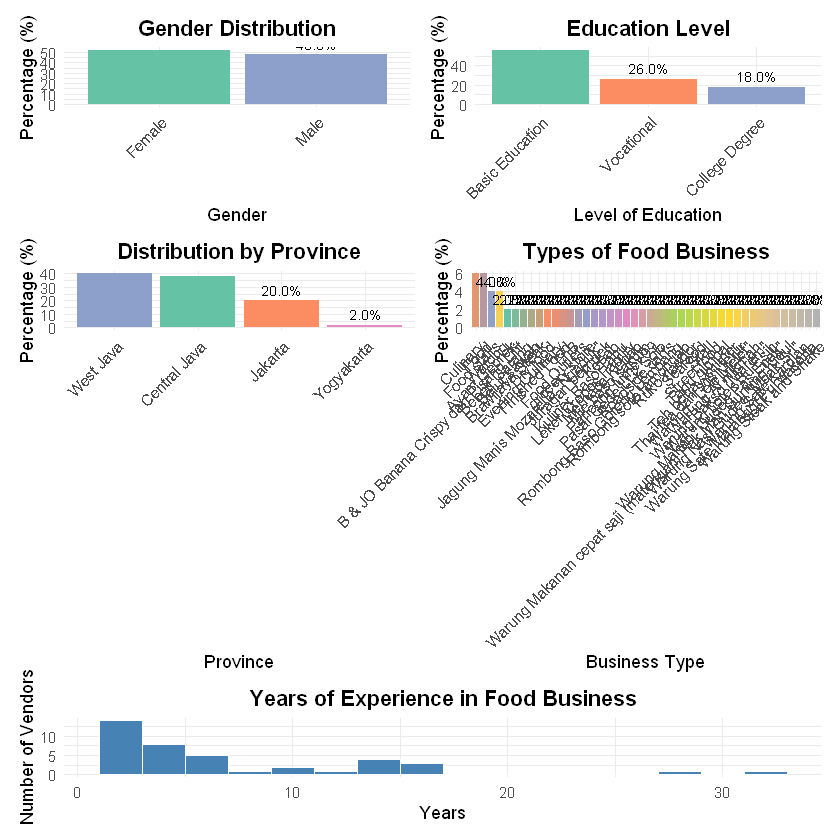

In [55]:
# Create demographic summary tables
gender_summary <- dataactor %>%
  count(Gender) %>%
  mutate(percentage = n / sum(n) * 100)

education_summary <- dataactor %>%
  count(Edu) %>%
  mutate(percentage = n / sum(n) * 100)

province_summary <- dataactor %>%
  count(Province) %>%
  mutate(percentage = n / sum(n) * 100)

business_type_summary <- dataactor %>%
  count(`Types of Shop`) %>%
  mutate(percentage = n / sum(n) * 100)

# Create function for consistent visualizations
create_bar_chart <- function(data, x_var, fill_var = NULL, title, x_lab, y_lab = "Percentage (%)") {
  # Count number of unique values for color palette
  if (is.null(fill_var)) fill_var <- x_var
  n_categories <- length(unique(data[[fill_var]]))
  
  # Create extended color palette if needed
  colors <- colorRampPalette(brewer.pal(min(8, n_categories), "Set2"))(n_categories)
  
  data %>%
    group_by(.data[[x_var]]) %>%
    summarise(count = n()) %>%
    mutate(percentage = count / sum(count) * 100) %>%
    ggplot(aes(x = reorder(.data[[x_var]], -percentage), y = percentage, fill = .data[[fill_var]])) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = sprintf("%.1f%%", percentage)), vjust = -0.5, size = 3) +
    scale_fill_manual(values = colors) +
    labs(title = title, x = x_lab, y = y_lab) +
    theme_minimal() +
    theme(legend.position = "none",
          axis.text.x = element_text(angle = 45, hjust = 1),
          plot.title = element_text(hjust = 0.5, face = "bold"))
}

# Create demographic visualizations
p1 <- create_bar_chart(dataactor, "Gender", title = "Gender Distribution", x_lab = "Gender")
p2 <- create_bar_chart(dataactor, "Edu", title = "Education Level", x_lab = "Level of Education")
p3 <- create_bar_chart(dataactor, "Province", title = "Distribution by Province", x_lab = "Province")
p4 <- create_bar_chart(dataactor, "Types of Shop", title = "Types of Food Business", x_lab = "Business Type")

# Create experience distribution chart
dataactor$`Time of Employment (Year)` <- as.numeric(as.character(dataactor$`Time of Employment (Year)`))

p5 <- ggplot(dataactor, aes(x = `Time of Employment (Year)`)) +
  geom_histogram(binwidth = 2, fill = "steelblue", color = "white") +
  labs(title = "Years of Experience in Food Business", 
       x = "Years", y = "Number of Vendors") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

# Arrange the plots in a grid
(p1 + p2) / (p3 + p4) / p5

## 2. Food Business Ownership and Legal Status

This section examines the ownership structure of food businesses and their compliance with legal requirements.

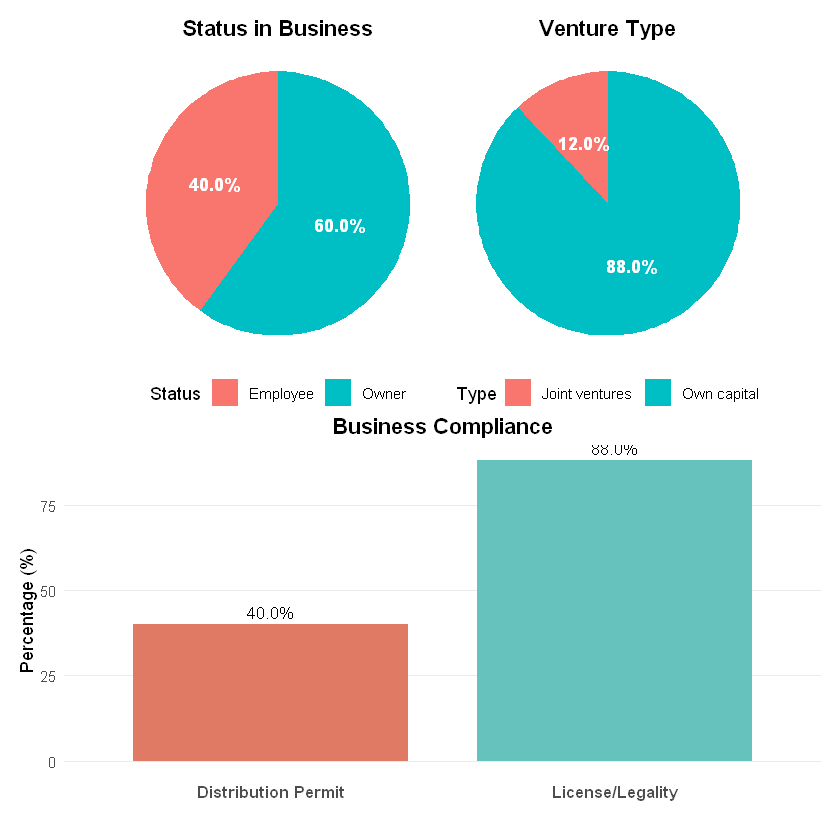

In [49]:
# Define ownership questions
qown <- c(
  "1. What is your status in this street vendor business?",
  "2. Is this business venture a joint venture or own capital?",
  "3. Does your business have a business license/legality?",
  "4. Does the product being sold have a distribution permit?"
)

# Create pie charts for ownership status and venture type
plot1 <- dataactor %>%
  count(`1. What is your status in this street vendor business?`) %>%
  mutate(percentage = n / sum(n) * 100,
         label = sprintf("%.1f%%", percentage)) %>%
  ggplot(aes(x = "", y = n, fill = `1. What is your status in this street vendor business?`)) +
  geom_bar(width = 1, stat = "identity") +
  geom_text(aes(label = label), 
            position = position_stack(vjust = 0.5), 
            color = "white", fontface = "bold") +
  coord_polar(theta = "y") +
  labs(title = "Status in Business", fill = "Status") +
  theme_void() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

plot2 <- dataactor %>%
  count(`2. Is this business venture a joint venture or own capital?`) %>%
  mutate(percentage = n / sum(n) * 100,
         label = sprintf("%.1f%%", percentage)) %>%
  ggplot(aes(x = "", y = n, fill = `2. Is this business venture a joint venture or own capital?`)) +
  geom_bar(width = 1, stat = "identity") +
  geom_text(aes(label = label), 
            position = position_stack(vjust = 0.5), 
            color = "white", fontface = "bold") +
  coord_polar(theta = "y") +
  labs(title = "Venture Type", fill = "Type") +
  theme_void() + 
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

# Create bar chart for license and permits
ownership_data <- data.frame(
  Category = c("License/Legality", "Distribution Permit"),
  Percentage = c(
    mean(dataactor[, qown[3]] == "Yes") * 100,
    mean(dataactor[, qown[4]] == "Yes") * 100
  )
)

plot3 <- ggplot(ownership_data, aes(x = Category, y = Percentage, fill = Category)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.9), width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", Percentage)), vjust = -0.5, size = 3.5) +
  scale_fill_manual(values = c("#E07A64", "#66C2BD")) +
  labs(title = "Business Compliance", x = "", y = "Percentage (%)") +
  theme_minimal() +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    axis.text.x = element_text(size = 10, face = "bold"),
    legend.position = "none",
    plot.title = element_text(hjust = 0.5, face = "bold")
  )

# Display the plots
(plot1 + plot2) / plot3

## 3. Leadership and Management Practices

This section analyzes how well food vendors implement leadership and management practices related to food safety.

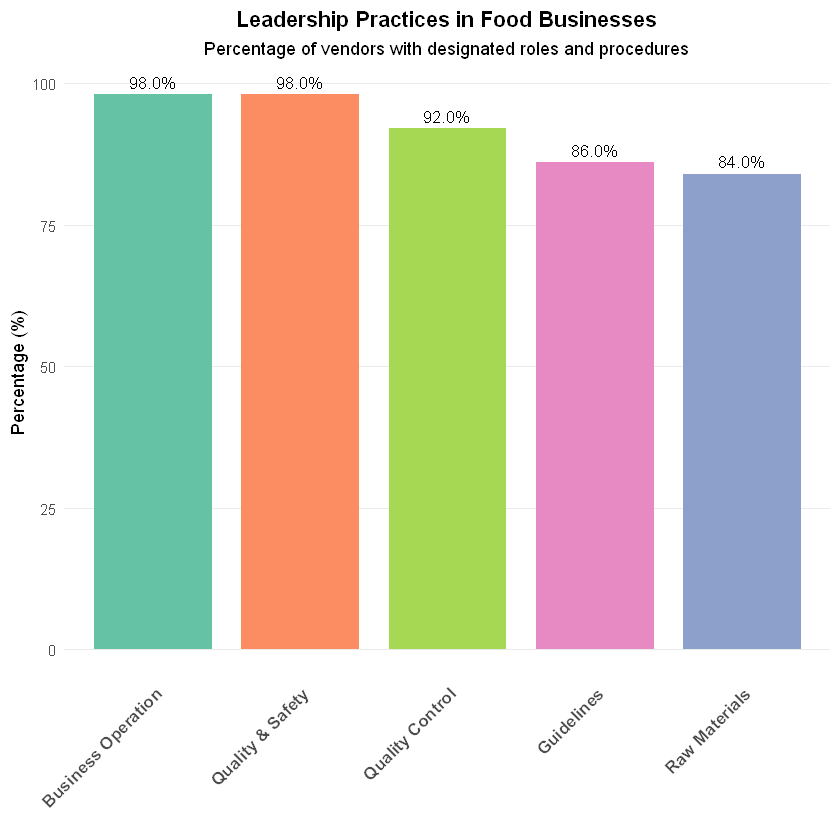

In [50]:
# Define leadership questions
qlead <- c(
  "5. Is there anyone in charge of this business operation?",
  "6. Is anyone responsible for the quality and safety of the food sold/produced?",
  "7. Is anyone responsible as suppliers for raw materials?",
  "8. Are there quality guidelines and procedures related to food safety in the business?",
  "9. Are there any provisions regarding raw materials and products that are not suitable for use or sale?"
)

# Create simplified question labels
lead_labels <- c(
  "Business Operation", 
  "Quality & Safety", 
  "Raw Materials", 
  "Guidelines", 
  "Quality Control"
)

# Calculate the proportion of "Yes" responses for each leadership question
leadership_data <- data.frame(
  Question = factor(lead_labels, levels = lead_labels),
  Percentage = sapply(qlead, function(q) {
    mean(dataactor[[q]] == "Yes") * 100
  })
)

# Create bar chart for leadership practices
ggplot(leadership_data, aes(x = reorder(Question, -Percentage), y = Percentage, fill = Question)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.9), width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", Percentage)), vjust = -0.5, size = 3.5) +
  scale_fill_brewer(palette = "Set2") +
  labs(
    title = "Leadership Practices in Food Businesses",
    subtitle = "Percentage of vendors with designated roles and procedures",
    x = "", 
    y = "Percentage (%)"
  ) +
  theme_minimal() +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    axis.text.x = element_text(size = 10, face = "bold", angle = 45, hjust = 1),
    legend.position = "none",
    plot.title = element_text(hjust = 0.5, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5)
  )

## 4. Planning and Customer Feedback

Examining how vendors plan their operations and utilize customer feedback.

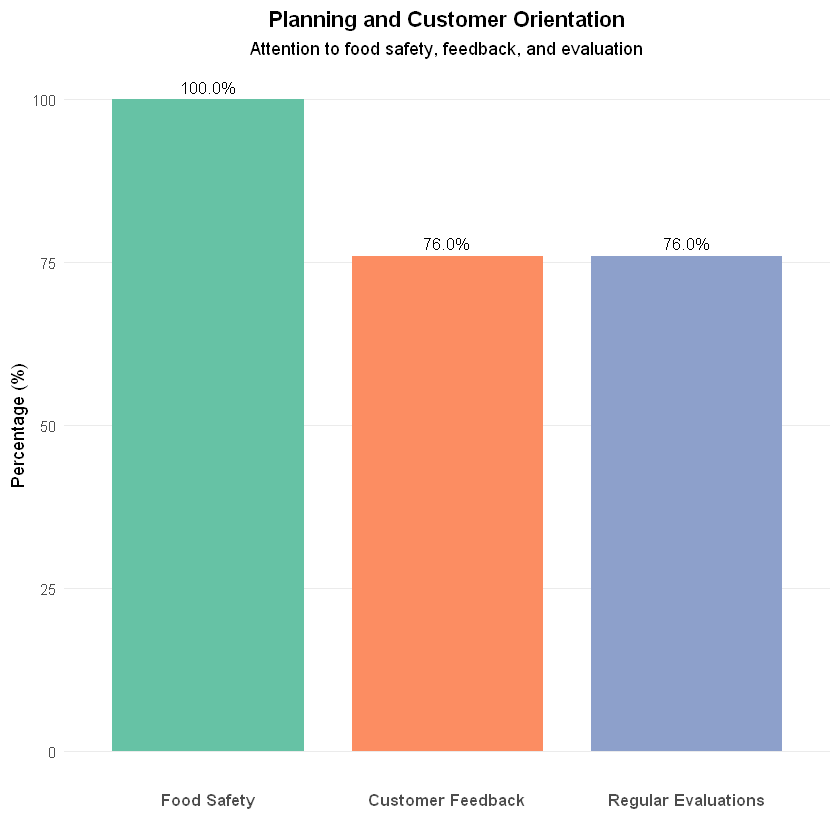

In [51]:
# Define planning questions
qplan <- c(
  "10. While working with food, do you pay attention to matters related to the cleanliness of the food (food safety) that is sold or produced?",
  "11. Does your business follow up the customer feedback for improvement?",
  "12. Does your business conduct annual or periodic evaluations?"
)

# Create simplified labels
plan_labels <- c("Food Safety", "Customer Feedback", "Regular Evaluations")

# Calculate percentages of "Yes" responses
planning_data <- data.frame(
  Category = factor(plan_labels, levels = plan_labels),
  Percentage = sapply(qplan, function(q) {
    mean(dataactor[[q]] == "Yes") * 100
  })
)

# Create bar chart for planning practices
ggplot(planning_data, aes(x = Category, y = Percentage, fill = Category)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.9), width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", Percentage)), vjust = -0.5, size = 3.5) +
  scale_fill_brewer(palette = "Set2") +
  labs(
    title = "Planning and Customer Orientation",
    subtitle = "Attention to food safety, feedback, and evaluation",
    x = "", 
    y = "Percentage (%)"
  ) +
  theme_minimal() +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    axis.text.x = element_text(size = 10, face = "bold"),
    legend.position = "none",
    plot.title = element_text(hjust = 0.5, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5)
  )

## 5. Human Resources and Personal Hygiene

This section examines the human resource practices and personal hygiene measures implemented by food vendors.

Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_text()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_text()`)."


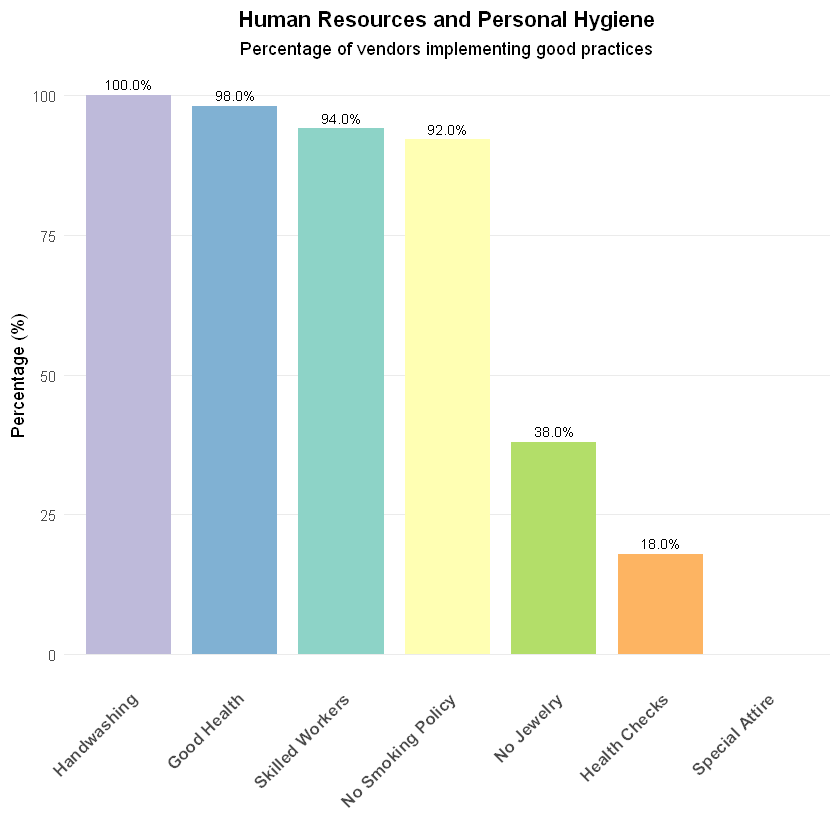

In [52]:
# Define human resources questions
qhr <- c(
  "13. Is this business run by workers with relevant experience or skills?",
  "15. Are workers allowed to smoke/vape during food preparation or handling?",
  "16. Do workers who handle food wash their hands before working?",
  "17. Do workers change clothes before work or wear special working attire?",
  "18. Do workers who work must be in good health?",
  "19. Are there any provisions for periodic health checks for workers?",
  "23. Is there any prohibition for workers who process food to wear jewelry, watches, brooches and others?"
)

# Create simplified labels
hr_labels <- c(
  "Skilled Workers",
  "No Smoking Policy",  # Note: This is reversed as "No" is the desired answer
  "Handwashing",
  "Special Attire",
  "Good Health",
  "Health Checks",
  "No Jewelry"
)

# Calculate percentages - with special handling for smoking question
hr_data <- data.frame(
  Question = factor(hr_labels, levels = hr_labels),
  Percentage = c(
    mean(dataactor[[qhr[1]]] == "Yes") * 100,
    mean(dataactor[[qhr[2]]] == "No") * 100,  # Reversed for "No smoking"
    mean(dataactor[[qhr[3]]] == "Yes") * 100,
    mean(dataactor[[qhr[4]]] == "Yes") * 100,
    mean(dataactor[[qhr[5]]] == "Yes") * 100,
    mean(dataactor[[qhr[6]]] == "Yes") * 100,
    mean(dataactor[[qhr[7]]] == "Yes") * 100
  )
)

# Create bar chart for human resources practices
ggplot(hr_data, aes(x = reorder(Question, -Percentage), y = Percentage, fill = Question)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.9), width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", Percentage)), vjust = -0.5, size = 3) +
  scale_fill_brewer(palette = "Set3") +
  labs(
    title = "Human Resources and Personal Hygiene",
    subtitle = "Percentage of vendors implementing good practices",
    x = "", 
    y = "Percentage (%)"
  ) +
  theme_minimal() +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    axis.text.x = element_text(size = 10, face = "bold", angle = 45, hjust = 1),
    legend.position = "none",
    plot.title = element_text(hjust = 0.5, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5)
  )

## 6. Protective Equipment Usage

Analyzing what types of protective equipment food handlers use during food preparation.

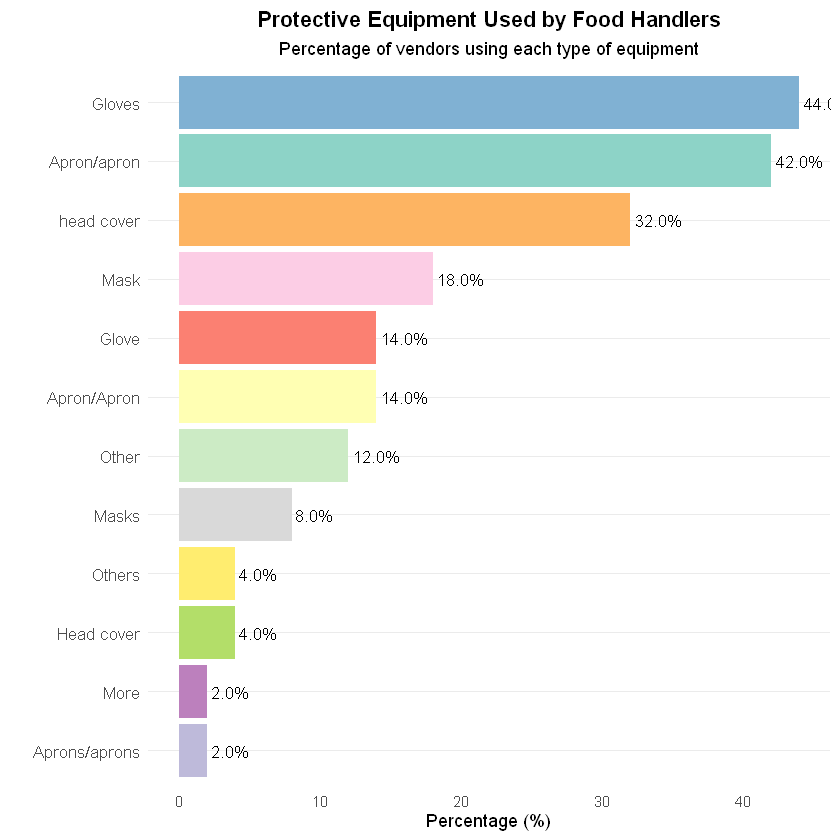

In [53]:
# Analyze protective equipment usage (Question 14)
equipment_col <- "14. What types of attributes do food processing workers use while working? (Choose the answers that suit you the best (you may choose more than one)"

# Create a data frame for equipment usage
equipment_data <- dataactor %>%
  select(all_of(equipment_col)) %>%
  separate_rows(all_of(equipment_col), sep = ", ") %>%
  count(!!sym(equipment_col)) %>%
  filter(!is.na(!!sym(equipment_col))) %>%
  mutate(percentage = n / nrow(dataactor) * 100) %>%
  arrange(desc(percentage))

# Create bar chart for protective equipment
ggplot(equipment_data, aes(x = reorder(!!sym(equipment_col), percentage), y = percentage, fill = !!sym(equipment_col))) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = sprintf("%.1f%%", percentage)), hjust = -0.1, size = 3.5) +
  scale_fill_brewer(palette = "Set3") +
  labs(
    title = "Protective Equipment Used by Food Handlers",
    subtitle = "Percentage of vendors using each type of equipment",
    x = "", 
    y = "Percentage (%)"
  ) +
  theme_minimal() +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    axis.text.y = element_text(size = 10),
    legend.position = "none",
    plot.title = element_text(hjust = 0.5, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5)
  ) +
  coord_flip()

## 7. Key Insights and Recommendations

Based on our analysis of food safety practices among street food vendors, here are the key insights and recommendations for stakeholders:

### Strengths:
1. High awareness of basic hygiene practices like handwashing before food handling (>90%)
2. Strong compliance with separating raw ingredients from cooked food (>85%)
3. Widespread adoption of cleaning food ingredients before processing (>95%)
4. Good maintenance of processing equipment and storage conditions for raw materials

### Areas for Improvement:
1. **Documentation Practices**: Less than 30% of vendors maintain records regarding expiration dates, cleaning schedules, or worker health checks
2. **Formal Training**: Only about 40% of workers have undergone formal food safety training
3. **Infrastructure**: Many vendors (approximately 40%) lack proper handwashing facilities with soap
4. **Protective Equipment**: Inconsistent use of protective gear like gloves and masks

### Recommendations:
1. **Training Programs**: Develop accessible, short-duration food safety training programs specifically tailored for street food vendors
2. **Simple Documentation Tools**: Create easy-to-use templates for basic record-keeping of cleaning schedules and expiration dates
3. **Infrastructure Support**: Support vendors in setting up basic handwashing stations
4. **Regular Monitoring**: Implement a simple monitoring system with incentives for compliance
5. **Customer Awareness**: Educate customers about food safety indicators to look for when purchasing street food

These insights and recommendations aim to enhance food safety practices among street food vendors while recognizing the practical constraints they operate under.